# FizzBuzz in TensorFlow

## Dataset

First, let's try to get the dataset for our problem. Here is a simple one-liner to prepare the training data

In [ ]:
def get_training_data(min_range:int = 1, max_range:int = 100):
    return {x: 'fizzbuzz' if x % 15==0 else "buzz" if x%5==0 else "fizz" if x%3 == 0 else x for x in range(min_range,max_range)}

In [ ]:
data = get_training_data(101, 2400)

test_data = get_training_data(1, 101)

## Machine Learning

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences

In [ ]:
labels = ['number', 'fizz','buzz','fizzbuzz']
sequence_length =4


def convert_to_vector(num):
    n = num
    out = []
    while n > 0:
        out.append(n%10)
        n //= 10
    
    return out[::-1]

def convert_to_int(label):
    if label in labels:
        return labels.index(label)
    else:
        return 0

def fizz_buzz_pred(i, prediction):
    return [str(i), "fizz", "buzz", "fizzbuzz"][prediction]


def convert_list_to_vector(data):
    out = np.array([convert_to_vector(x) for x in data],dtype=object)
    return pad_sequences(out, maxlen=sequence_length)

def convert_list_to_int(data):
    return np.array([convert_to_int(x) for x in data])

In [ ]:
X = convert_list_to_vector(data.keys())
y = convert_list_to_int(data.values())

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2,shuffle=True)

In [ ]:
X_train[:5],y_train[:5]

(array([[2, 3, 3, 0],
        [1, 1, 0, 5],
        [0, 1, 3, 5],
        [1, 9, 0, 4],
        [0, 9, 1, 0]], dtype=int32),
 array([2, 2, 3, 0, 2]))

## Training

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import *

from keras_lr_finder import LRFinder
from keras_contrib.callbacks.cyclical_learning_rate import CyclicLR
from tensorflow.keras.optimizers import SGD
import tensorflow_addons as tfa

from tqdm.keras import TqdmCallback
from keras_tqdm import TQDMCallback, TQDMNotebookCallback


In [ ]:

embed_size = 3
model = tf.keras.Sequential()
model.add(Input(shape=(sequence_length,)))

model.add(Embedding(10, embed_size, trainable=True ))

model.add(Conv1D(64, kernel_size=2, padding='same',kernel_initializer=tf.keras.initializers.HeNormal(), activation='relu'))
model.add(MaxPool1D(pool_size=3, strides=1, padding='valid'))
model.add(GlobalAveragePooling1D())
model.add(Dense(32, activation='relu',kernel_initializer=tf.keras.initializers.HeNormal()))
model.add(Dropout(0.2))
model.add(Dense(4, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop', metrics=['sparse_categorical_accuracy'])

Epoch 1/2
29/29 [==============================] - 0s 2ms/step - loss: 1.2888 - sparse_categorical_accuracy: 0.3997
Epoch 2/2
29/29 [==============================] - 0s 468us/step - loss: 27.6597 - sparse_categorical_accuracy: 0.4643


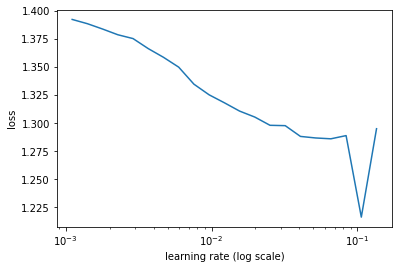

In [ ]:
lr_finder = LRFinder(model)

lr_finder.find(X_train, y_train, start_lr=1e-4, end_lr=100, batch_size=64,epochs=2)

lr_finder.plot_loss()


In [ ]:
ACCURACY_THRESHOLD = 0.999
class myCallback(tf.keras.callbacks.Callback):
    """ Callback to update the parent bar and also stop the training after reaching 99% accuracy """
    
    def __init__(self, tqdm_callback, print_n=100):
        self.print_n = print_n
        self.tqdm_callback = tqdm_callback
        
    def on_epoch_end(self, epoch, logs={}):
        self.params = {'metrics':['loss']}
        if(logs.get('val_sparse_categorical_accuracy') > ACCURACY_THRESHOLD):
            print('Reached %2.2f%% accuracy, on the epoch %d so stopping training' %(ACCURACY_THRESHOLD, epoch))
            self.model.stop_training=True
            
        if epoch % self.print_n == 0:
            self.tqdm_callback.tqdm_outer.desc = "Val Acc / epoch: {} / {}".format(logs.get('val_sparse_categorical_accuracy'), epoch)
            self.tqdm_callback.tqdm_outer.update(1)

In [ ]:


tqdm_callback = TQDMNotebookCallback(leave_inner=False, show_inner=False,show_outer=True)
callbacks = myCallback(tqdm_callback, print_n=10)
# 3. Fit using Callback
clr = CyclicLR(base_lr = 0.001, max_lr = 0.01, step_size=1000, mode='triangular')
#model.fit(X_train, y_train, batch_size = 128, epochs=2, callbacks= [lr_finder])

model.fit(X_train, y_train, validation_data=(X_test, y_test), callbacks=[callbacks,clr,tqdm_callback], verbose=0, epochs=4000, batch_size=64)

Training:   0%|          | 0/4000 [00:00<?, ?it/s]

Reached 1.00% accuracy, on the epoch 54 so stopping training


In [ ]:
model.evaluate(X_test, y_test)

4/4 [==============================] - 0s 1ms/step - loss: 0.0193 - sparse_categorical_accuracy: 1.0000


[0.01926736906170845, 1.0]

## Evaluation

In [ ]:
X_test = convert_list_to_vector(test_data.keys())
y_test = convert_list_to_int(test_data.values())

In [ ]:
model.evaluate(X_test, y_test)

4/4 [==============================] - 0s 1ms/step - loss: 0.0193 - sparse_categorical_accuracy: 1.0000


[0.01926736906170845, 1.0]

In [ ]:
inputs = np.array(list(range(1,101)))
input_vector = list(map(convert_to_vector, inputs))
input_vector = pad_sequences(np.array(input_vector, dtype=object), maxlen=sequence_length)

predictions = model(input_vector).numpy()


def convert_fb(num):
    if num % 15 == 0:
        return "fizzbuzz"
    
    elif num % 3 == 0:
        return "fizz"
    
    elif num % 5 == 0:
        return "buzz"
    
    else:
        return str(num)
    
acc = 0
total = 0
for i,inp in enumerate(inputs):
    pred = np.argmax(predictions[i])
    print(inp, fizz_buzz_pred(inp, pred), convert_fb(inp), predictions[i][pred])
    
    acc += 1 if fizz_buzz_pred(inp, pred) == convert_fb(inp) else 0
    total += 1
    
print(f'Accuracy = {acc*1.0 / total}')
    
    

1 1 1 0.9999939
2 2 2 1.0
3 fizz fizz 0.8921745
4 4 4 0.9999964
5 buzz buzz 0.9999999
6 fizz fizz 0.97546935
7 7 7 0.9999838
8 8 8 1.0
9 fizz fizz 0.9918276
10 buzz buzz 1.0
11 11 11 0.99862516
12 fizz fizz 0.96120465
13 13 13 1.0
14 14 14 0.9994443
15 fizzbuzz fizzbuzz 0.973569
16 16 16 1.0
17 17 17 0.9992423
18 fizz fizz 0.96867096
19 19 19 1.0
20 buzz buzz 1.0
21 fizz fizz 0.9952963
22 22 22 1.0
23 23 23 1.0
24 fizz fizz 0.9864107
25 buzz buzz 0.99964535
26 26 26 1.0
27 fizz fizz 0.98947936
28 28 28 1.0
29 29 29 1.0
30 fizzbuzz fizzbuzz 0.9998398
31 31 31 0.8273142
32 32 32 1.0
33 fizz fizz 0.99971443
34 34 34 0.95565426
35 buzz buzz 1.0
36 fizz fizz 0.9998672
37 37 37 0.95040554
38 38 38 1.0
39 fizz fizz 0.9999325
40 buzz buzz 1.0
41 41 41 0.999345
42 fizz fizz 0.9749287
43 43 43 1.0
44 44 44 0.9998099
45 fizzbuzz fizzbuzz 0.9845994
46 46 46 1.0
47 47 47 0.99976116
48 fizz fizz 0.9781506
49 49 49 1.0
50 buzz buzz 1.0
51 fizz fizz 0.9736729
52 52 52 0.83498245
53 53 53 1.0
54 fizz f